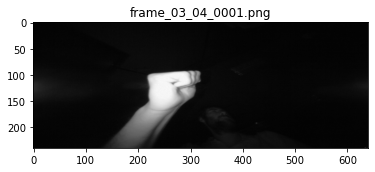

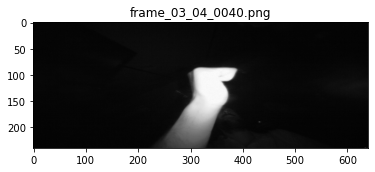

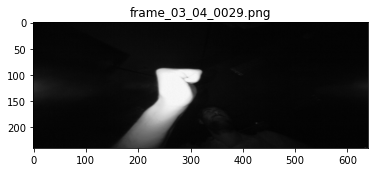

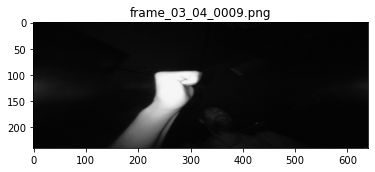

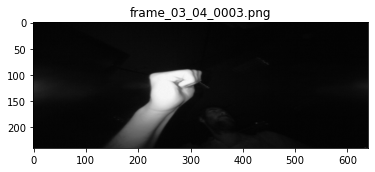

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

# Path to the main dataset folder
dataset_path = 'dataset/leapGestRecog'

# List to store image paths
image_files = []

# Loop through all the session folders (00, 01, ...)
for session in os.listdir(dataset_path):
    session_path = os.path.join(dataset_path, session)
    
    # Loop through all gesture folders within a session
    for gesture in os.listdir(session_path):
        gesture_path = os.path.join(session_path, gesture)
        
        # Loop through all images in a gesture folder
        for img_file in os.listdir(gesture_path):
            if img_file.endswith('.png'):
                image_files.append(os.path.join(gesture_path, img_file))

# Check if there are enough images to display
if len(image_files) < 5:
    print(f"Only {len(image_files)} images found. Please check the dataset.")
else:
    # Display a few images
    for i in range(5):
        img = cv2.imread(image_files[i])
        if img is not None:  # Ensure the image was loaded correctly
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.title(os.path.basename(image_files[i]))
            plt.show()
        else:
            print(f"Error loading image {image_files[i]}")

In [2]:
 %pip install colabcode

INFO: pip is looking at multiple versions of colabcode to determine which version is compatible with other requirements. This could take a while.
  Using cached uvicorn-0.13.1-py3-none-any.whl.metadata (4.6 kB)
  Using cached uvicorn-0.13.1-py3-none-any.whl.metadata (4.6 kB)
Note: you may need to restart the kernel to use updated packages.


Requested uvicorn==0.13.1 from https://files.pythonhosted.org/packages/ef/67/546c35e9fffb585ea0608ba3bdcafe17ae402e304367203d0b08d6c23051/uvicorn-0.13.1-py3-none-any.whl (from colabcode) has invalid metadata: .* suffix can only be used with `==` or `!=` operators
    python-dotenv (>=0.13.*) ; extra == 'standard'
                   ~~~~~~~^
Please use pip<24.1 if you need to use this version.
Requested uvicorn==0.13.1 from https://files.pythonhosted.org/packages/ef/67/546c35e9fffb585ea0608ba3bdcafe17ae402e304367203d0b08d6c23051/uvicorn-0.13.1-py3-none-any.whl (from colabcode) has invalid metadata: .* suffix can only be used with `==` or `!=` operators
    python-dotenv (>=0.13.*) ; extra == 'standard'
                   ~~~~~~~^
Please use pip<24.1 if you need to use this version.
Requested uvicorn==0.13.1 from https://files.pythonhosted.org/packages/ef/67/546c35e9fffb585ea0608ba3bdcafe17ae402e304367203d0b08d6c23051/uvicorn-0.13.1-py3-none-any.whl (from colabcode) has invalid metadata:

In [2]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Define image dimensions
img_size = 128

# Lists to store images and labels
images = []
labels = []

# Loop through the image files to preprocess them
for img_path in image_files:
    # Load image
    img = cv2.imread(img_path)
    
    # Resize image to the defined size
    img = cv2.resize(img, (img_size, img_size))
    
    # Normalize image
    img = img / 255.0
    
    # Append image and corresponding label (folder name)
    images.append(img)
    labels.append(os.path.basename(os.path.dirname(img_path)))

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-08-15 16:00:21.076189: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-15 16:00:23.379793: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-15 16:00:24.583329: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 16:00:25.721964: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 16:00:25.960431: E external/loc

Images shape: (4987, 128, 128, 3)
Labels shape: (4987,)


In [3]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform labels
labels_encoded = label_encoder.fit_transform(labels)

# Convert labels to one-hot encoding
labels_one_hot = to_categorical(labels_encoded)

print(f"Encoded labels shape: {labels_one_hot.shape}")

Encoded labels shape: (4987, 10)


In [4]:
from sklearn.model_selection import train_test_split

# Split the data: 80% training, 20% validation
X_train, X_val, y_train, y_val = train_test_split(images, labels_one_hot, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

Training set: (3989, 128, 128, 3), (3989, 10)
Validation set: (998, 128, 128, 3), (998, 10)


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

/home/zesh/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,930 (12.61 MB)

 Trainable params: 3,305,930 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

# Save the model for future use
model.save('hand_gesture_recognition_model.h5')


2024-08-15 16:17:24.325568: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 784269312 exceeds 10% of free system memory.


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.3973 - loss: 1.6594

2024-08-15 16:18:47.556134: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 196214784 exceeds 10% of free system memory.


125/125 ━━━━━━━━━━━━━━━━━━━━ 86s 659ms/step - accuracy: 0.3991 - loss: 1.6546 - val_accuracy: 0.9880 - val_loss: 0.0645
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 142s 665ms/step - accuracy: 0.9311 - loss: 0.1986 - val_accuracy: 0.9950 - val_loss: 0.0235
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 656ms/step - accuracy: 0.9634 - loss: 0.1102 - val_accuracy: 0.9970 - val_loss: 0.0173
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 140s 644ms/step - accuracy: 0.9829 - loss: 0.0570 - val_accuracy: 0.9980 - val_loss: 0.0166
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 606ms/step - accuracy: 0.9805 - loss: 0.0589 - val_accuracy: 0.9980 - val_loss: 0.0124
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 603ms/step - accuracy: 0.9795 - loss: 0.0561 - val_accuracy: 0.9980 - val_loss: 0.0095
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 609ms/step - accuracy: 0.9827 - loss: 0.0432 - val_accuracy: 0.9970 - val_loss: 0.0109
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 80s 640ms/step - accuracy: 0.9861 - loss: 0.0371 - v

In [7]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation accuracy: {val_accuracy*100:.2f}%")


 1/32 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 1.0000 - loss: 1.2591e-05

2024-08-15 16:33:21.728702: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 196214784 exceeds 10% of free system memory.


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9984 - loss: 0.0033
Validation accuracy: 99.90%


In [8]:
# Save the trained model
model.save('hand_gesture_recognition_model.h5')
print("Model saved as 'hand_gesture_recognition_model.h5'")

Model saved as 'hand_gesture_recognition_model.h5'


In [9]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('hand_gesture_recognition_model.h5')
print("Model loaded successfully")

Model loaded successfully


In [10]:
# Load a test image
test_img_path = 'dataset/leapGestRecog/00/01_palm/frame_00_01_0001.png'  # Example path, replace with actual path

# Preprocess the image: resize and normalize
test_img = cv2.imread(test_img_path)
test_img = cv2.resize(test_img, (img_size, img_size))
test_img = test_img / 255.0

# Add batch dimension (1, height, width, channels)
test_img = np.expand_dims(test_img, axis=0)

# Predict the class of the image
prediction = model.predict(test_img)
predicted_class = np.argmax(prediction, axis=1)

# Convert the predicted class back to the gesture label
predicted_label = label_encoder.inverse_transform(predicted_class)

print(f"Predicted Gesture: {predicted_label[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Predicted Gesture: 01_palm


In [11]:
# Test on multiple images
test_images = [os.path.join(dataset_path, '00/01_palm/frame_00_01_0001.png'), 
               os.path.join(dataset_path, '01/02_l/frame_01_02_0001.png')]

for img_path in test_images:
    test_img = cv2.imread(img_path)
    test_img = cv2.resize(test_img, (img_size, img_size))
    test_img = test_img / 255.0
    test_img = np.expand_dims(test_img, axis=0)

    prediction = model.predict(test_img)
    predicted_class = np.argmax(prediction, axis=1)
    predicted_label = label_encoder.inverse_transform(predicted_class)

    print(f"Image: {os.path.basename(img_path)} - Predicted Gesture: {predicted_label[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Image: frame_00_01_0001.png - Predicted Gesture: 01_palm
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Image: frame_01_02_0001.png - Predicted Gesture: 02_l


In [14]:
import gradio as gr
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder

# Load the saved model
model = load_model('hand_gesture_recognition_model.h5')

# Define the label encoder
label_encoder = LabelEncoder()
gesture_labels = ['palm', 'l', 'fist', 'fist_moved', 'thumb', 'index', 'ok', 'palm_moved', 'c', 'down']
label_encoder.fit(gesture_labels)

# Define the image size
img_size = 128

# Prediction function
def predict_gesture(image):
    # Convert the PIL image to a numpy array
    image = np.array(image)
    
    # Preprocess the image: resize and normalize
    image = cv2.resize(image, (img_size, img_size))
    image = image / 255.0
    image = np.expand_dims(image, axis=0)

    # Predict the gesture
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction, axis=1)
    predicted_label = label_encoder.inverse_transform(predicted_class)

    return predicted_label[0]

# Create the Gradio interface
interface = gr.Interface(
    fn=predict_gesture,
    inputs=gr.Image(),  # No shape parameter needed
    outputs=gr.Textbox(),
    title="Hand Gesture Recognition",
    description="Upload an image of a hand gesture, and the model will predict the gesture."
)

# Launch the interface
interface.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
